In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [62]:
df = pd.read_csv("../data/customer_intelligence_dataset.csv")
print("Rows, Cols:", df.shape)
display(df.head(10))
print("\nColumns:", list(df.columns))
print("\nDuplicate rows:")
print(df.duplicated().sum())
print("\nDescription:", df.info())


Rows, Cols: (8000, 18)


,sale_id,customer_id,product_id,product_name,category,price,quantity,sale_date,total_value,age,gender,region,segment,churn,tenure_months,last_purchase_date,feedback_text,sentiment
0,S000001,CUST01553,P004,Desk,Furniture,12000,2,2020-01-07,24000,40,Female,West,Small Business,1,37,2023-04-04,"Terrible experience, will not buy again.",Negative
1,S000002,CUST00161,P010,Projector,Electronics,45000,2,2023-11-10,90000,50,Female,West,Corporate,0,44,2023-03-02,Excellent customer service.,Positive
2,S000003,CUST00627,P010,Projector,Electronics,45000,4,2022-07-04,180000,33,Male,South,Corporate,0,25,2023-11-04,Product quality could be better.,Neutral
3,S000004,CUST01291,P009,Monitor,Electronics,12000,1,2023-10-18,12000,41,Male,West,Consumer,0,56,2023-08-18,"Delivery was late, not happy.",Positive
4,S000005,CUST01456,P004,Desk,Furniture,12000,4,2023-09-13,48000,60,Female,West,Consumer,0,52,2023-05-14,"Delivery was late, not happy.",Positive
5,S000006,CUST00634,P007,Pen Pack,Office Supplies,50,5,2022-10-22,250,51,Female,South,Consumer,0,43,2023-11-14,Product quality could be better.,Neutral
6,S000007,CUST01463,P005,Printer,Electronics,15000,1,2022-05-07,15000,57,Male,South,Consumer,0,59,2023-01-18,Excellent customer service.,Positive
7,S000008,CUST00235,P010,Projector,Electronics,45000,3,2020-04-19,135000,35,Male,East,Corporate,1,35,2023-06-28,"Terrible experience, will not buy again.",Negative
8,S000009,CUST01822,P010,Projector,Electronics,45000,5,2023-01-14,225000,24,Female,South,Small Business,1,57,2023-05-26,Excellent customer service.,Positive
9,S000010,CUST01772,P002,Smartphone,Electronics,25000,2,2022-05-16,50000,53,Male,East,Consumer,0,11,2023-03-05,"Delivery was late, not happy.",Positive



Columns: ['sale_id', 'customer_id', 'product_id', 'product_name', 'category', 'price', 'quantity', 'sale_date', 'total_value', 'age', 'gender', 'region', 'segment', 'churn', 'tenure_months', 'last_purchase_date', 'feedback_text', 'sentiment']

Duplicate rows:
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sale_id             8000 non-null   object
 1   customer_id         8000 non-null   object
 2   product_id          8000 non-null   object
 3   product_name        8000 non-null   object
 4   category            8000 non-null   object
 5   price               8000 non-null   int64 
 6   quantity            8000 non-null   int64 
 7   sale_date           8000 non-null   object
 8   total_value         8000 non-null   int64 
 9   age                 8000 non-null   int64 
 10  gender              8000 non-null   object
 11  r

In [63]:
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
df = df.drop(columns=["total_value"])
df['total_value'] = df['price'] * df['quantity']
df["total_value_log"] = np.log1p(df["total_value"])


Data types:
sale_id               object
customer_id           object
product_id            object
product_name          object
category              object
price                  int64
quantity               int64
sale_date             object
total_value            int64
age                    int64
gender                object
region                object
segment               object
churn                  int64
tenure_months          int64
last_purchase_date    object
feedback_text         object
sentiment             object
dtype: object

Missing values per column:
sale_id               0
customer_id           0
feedback_text         0
last_purchase_date    0
tenure_months         0
churn                 0
segment               0
region                0
gender                0
age                   0
total_value           0
sale_date             0
quantity              0
price                 0
category              0
product_name          0
product_id            0
sentiment      

In [64]:
for c in ["sale_date", "last_purchase_date"]:
    df[c] = pd.to_datetime(df[c], errors="coerce")

df["sale_year"]    = df["sale_date"].dt.year.astype("Int16")
df["sale_month"]   = df["sale_date"].dt.month.astype("Int8")
df["sale_day"]     = df["sale_date"].dt.day.astype("Int8")
df["sale_dow"]     = df["sale_date"].dt.dayofweek.astype("Int8")  # 0=Mon ... 6=Sun
df["is_weekend"]   = (df["sale_dow"] >= 5).astype("uint8")    

for c in ["sale_id", "customer_id", "product_id", "product_name"]:
    df[c] = df[c].astype("string")

for c in ["gender", "region", "segment", "category", "sentiment"]:
    df[c] = df[c].astype("category")



In [65]:
assert set(df["churn"].unique()) <= {0, 1}, f"Unexpected churn values: {df['churn'].unique()}"
df["churn"] = df["churn"].astype("uint8")
df.head()

,sale_id,customer_id,product_id,product_name,category,price,quantity,sale_date,age,gender,...,last_purchase_date,feedback_text,sentiment,total_value,total_value_log,sale_year,sale_month,sale_day,sale_dow,is_weekend
0,S000001,CUST01553,P004,Desk,Furniture,12000,2,2020-01-07,40,Female,...,2023-04-04,"Terrible experience, will not buy again.",Negative,24000,10.085851,2020,1,7,1,0
1,S000002,CUST00161,P010,Projector,Electronics,45000,2,2023-11-10,50,Female,...,2023-03-02,Excellent customer service.,Positive,90000,11.407576,2023,11,10,4,0
2,S000003,CUST00627,P010,Projector,Electronics,45000,4,2022-07-04,33,Male,...,2023-11-04,Product quality could be better.,Neutral,180000,12.100718,2022,7,4,0,0
3,S000004,CUST01291,P009,Monitor,Electronics,12000,1,2023-10-18,41,Male,...,2023-08-18,"Delivery was late, not happy.",Positive,12000,9.392745,2023,10,18,2,0
4,S000005,CUST01456,P004,Desk,Furniture,12000,4,2023-09-13,60,Female,...,2023-05-14,"Delivery was late, not happy.",Positive,48000,10.778977,2023,9,13,2,0


In [66]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns:", num_cols)
display(df[num_cols].describe().T if num_cols else "No numeric columns found.")



Numeric columns: ['price', 'quantity', 'age', 'churn', 'tenure_months', 'total_value', 'total_value_log', 'sale_year', 'sale_month', 'sale_day', 'sale_dow', 'is_weekend']


,count,mean,std,min,25%,50%,75%,max
price,8000.0,19091.19375,21398.129086,50.0,3000.0,12000.0,25000.0,70000.0
quantity,8000.0,2.997,1.414122,1.0,2.0,3.0,4.0,5.0
age,8000.0,41.483875,13.331802,18.0,30.0,42.0,53.0,64.0
churn,8000.0,0.248125,0.431952,0.0,0.0,0.0,0.0,1.0
tenure_months,8000.0,29.721125,17.342821,1.0,14.0,30.0,45.0,59.0
total_value,8000.0,57801.70625,77182.675351,50.0,8000.0,30000.0,70000.0,350000.0
total_value_log,8000.0,9.538462,2.409999,3.931826,8.987322,10.308986,11.156265,12.765691
sale_year,8000.0,2021.471,1.120297,2020.0,2020.0,2021.0,2022.0,2023.0
sale_month,8000.0,6.541375,3.455797,1.0,4.0,7.0,10.0,12.0
sale_day,8000.0,15.72425,8.719946,1.0,8.0,16.0,23.0,31.0


In [67]:
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("\nCategorical columns:", cat_cols)
for c in cat_cols[:5]:
    print(f"\nTop 10 values for '{c}':")
    print(df[c].value_counts(dropna=False).head(10))


Categorical columns: ['sale_id', 'customer_id', 'product_id', 'product_name', 'category', 'sale_date', 'gender', 'region', 'segment', 'last_purchase_date', 'feedback_text', 'sentiment']

Top 10 values for 'sale_id':
sale_id
S000001    1
S005330    1
S005343    1
S005342    1
S005341    1
S005340    1
S005339    1
S005338    1
S005337    1
S005336    1
Name: count, dtype: Int64

Top 10 values for 'customer_id':
customer_id
CUST01598    12
CUST01425    12
CUST00498    12
CUST00047    10
CUST00999    10
CUST01966    10
CUST01805    10
CUST00684    10
CUST00754    10
CUST00376    10
Name: count, dtype: Int64

Top 10 values for 'product_id':
product_id
P007    831
P001    817
P003    809
P009    801
P005    801
P010    799
P006    790
P004    787
P002    783
P008    782
Name: count, dtype: Int64

Top 10 values for 'product_name':
product_name
Pen Pack        831
Laptop          817
Office Chair    809
Monitor         801
Printer         801
Projector       799
Notebook        790
Desk     

In [68]:

top_customers = df.groupby('customer_id')['total_value'].sum().sort_values(ascending=False).head(10)
print("Top 10 highest paying customers:")
display(top_customers)

Top 10 highest paying customers:


customer_id
CUST01139    1150000
CUST01304    1041000
CUST01568    1035000
CUST01224    1026000
CUST00379     985200
CUST00684     958900
CUST01076     957050
CUST00804     954600
CUST00312     915000
CUST00414     910000
Name: total_value, dtype: int64

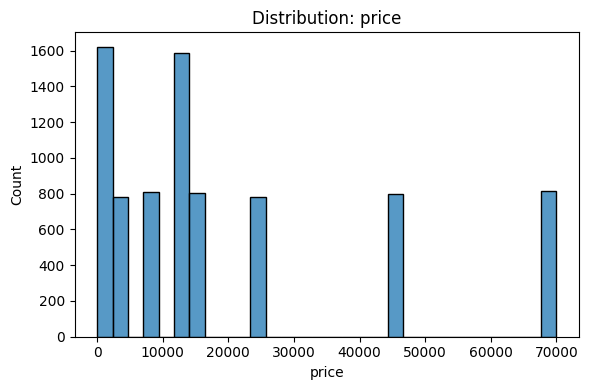

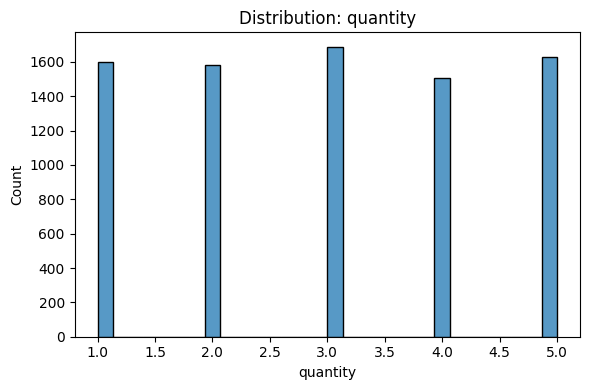

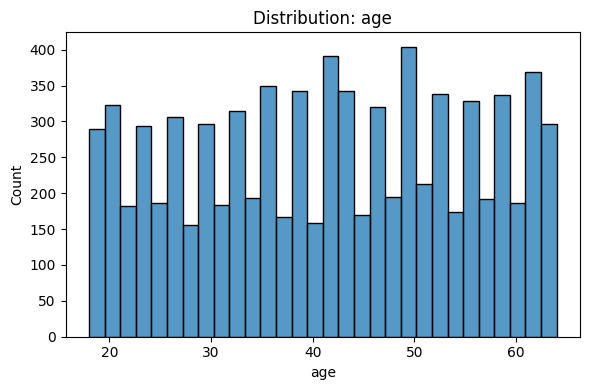

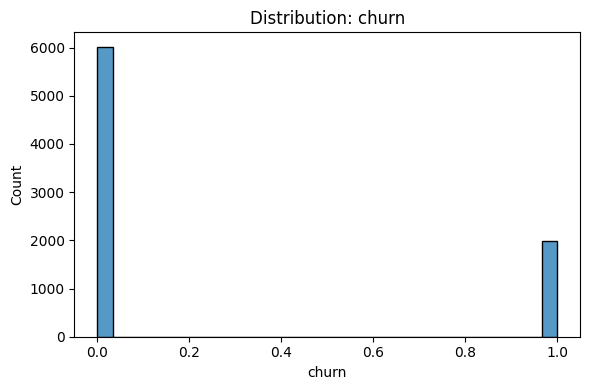

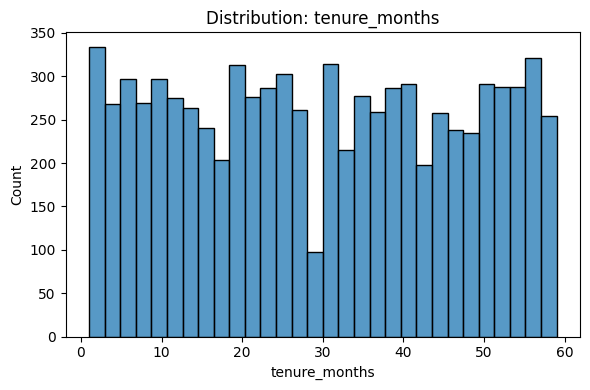

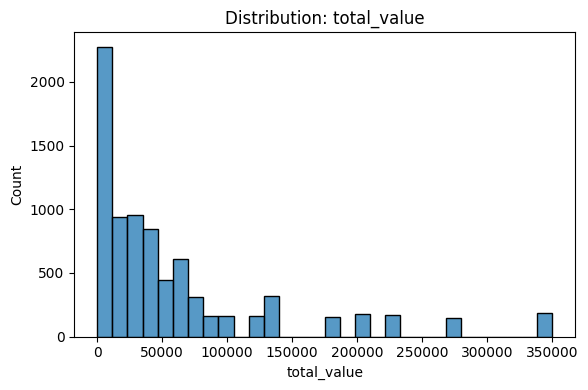

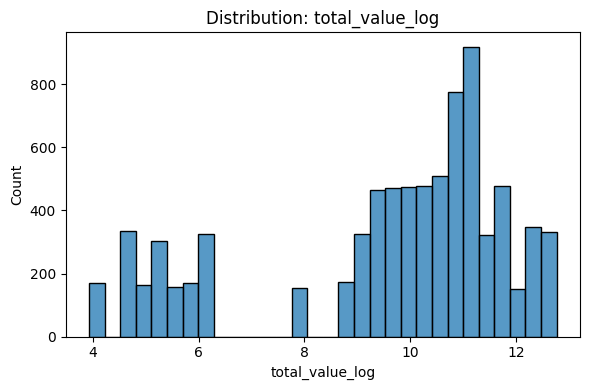

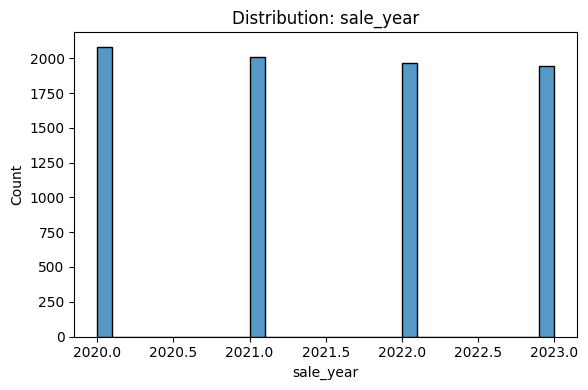

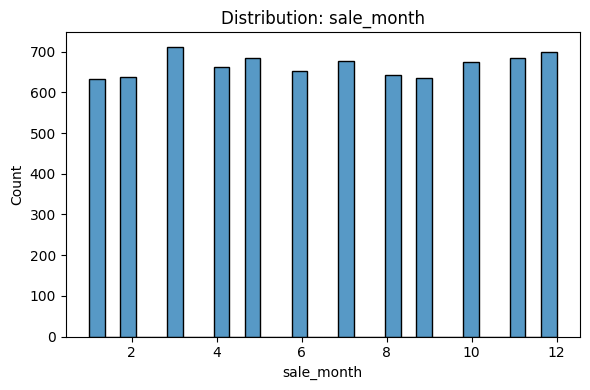

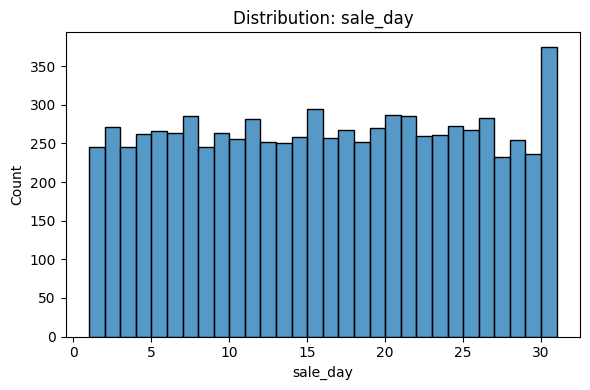

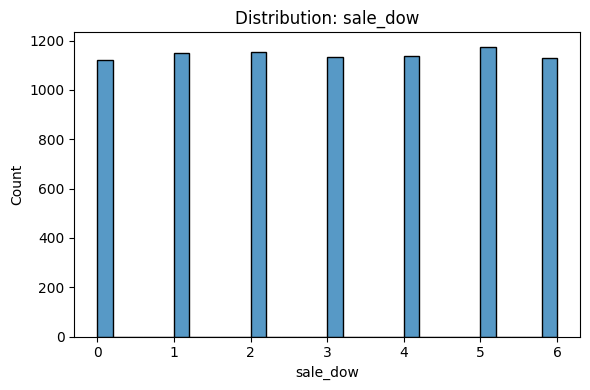

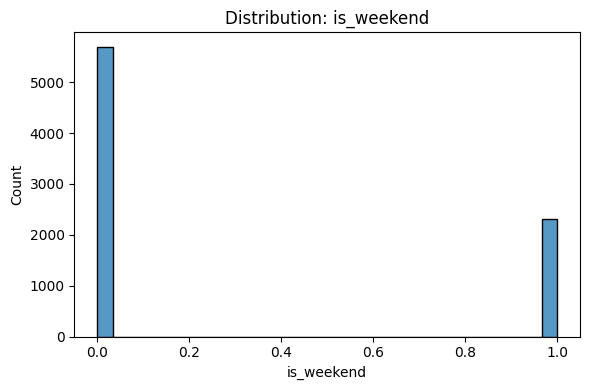

In [69]:
for c in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[c].dropna(), bins=30, kde=False)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

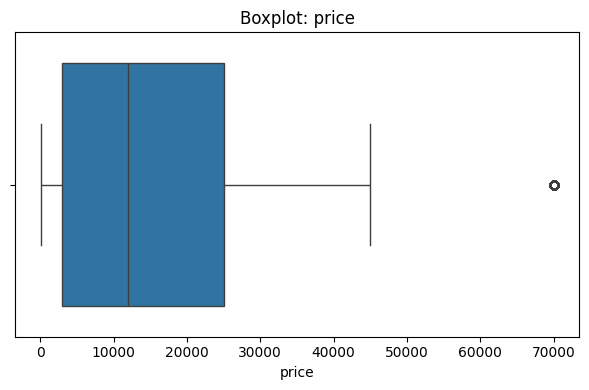

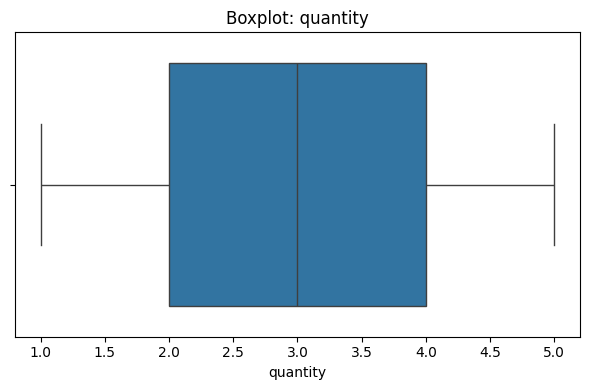

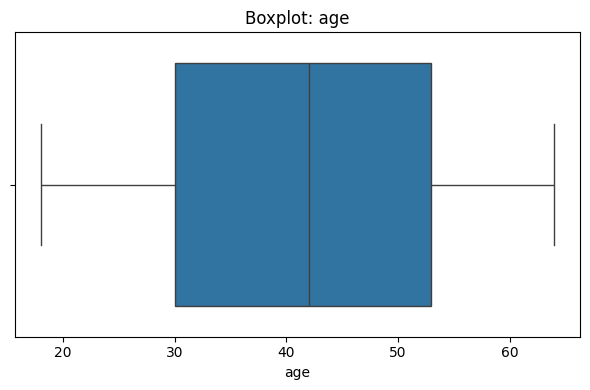

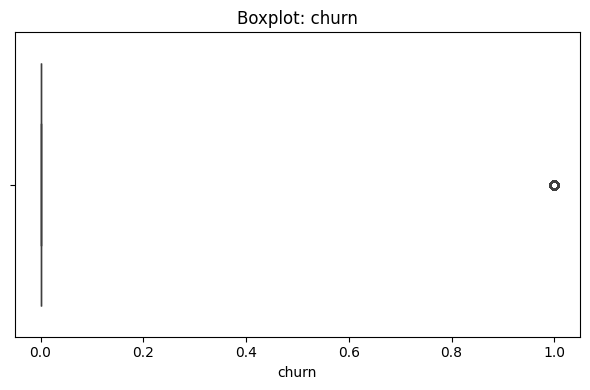

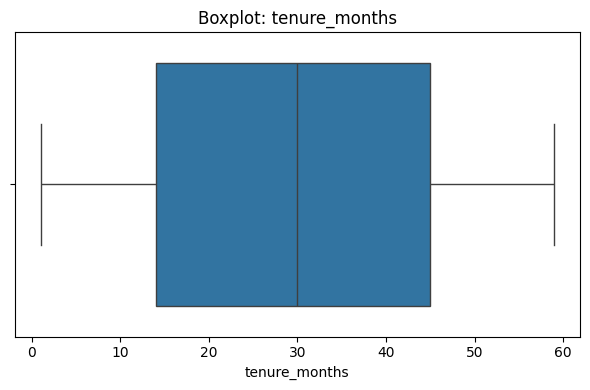

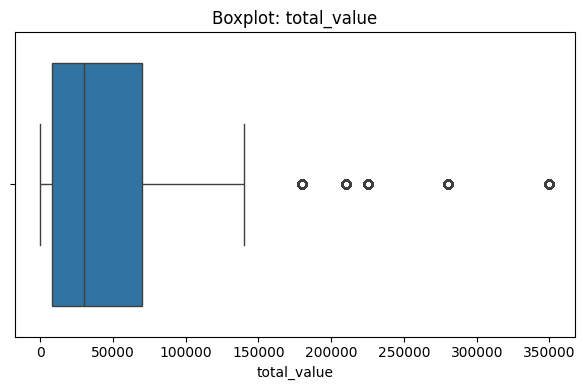

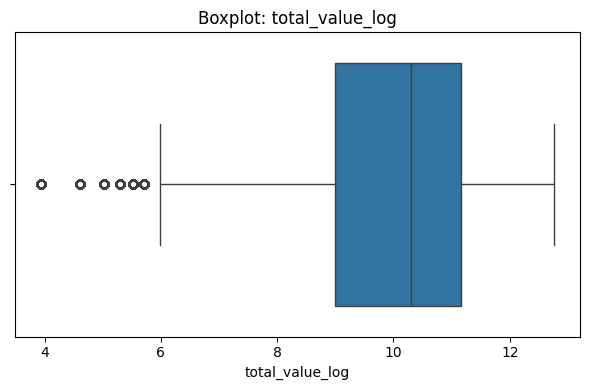

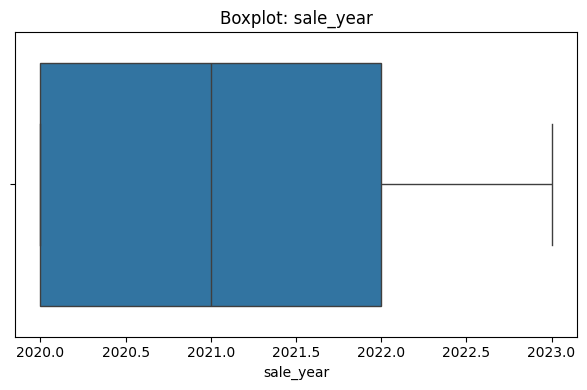

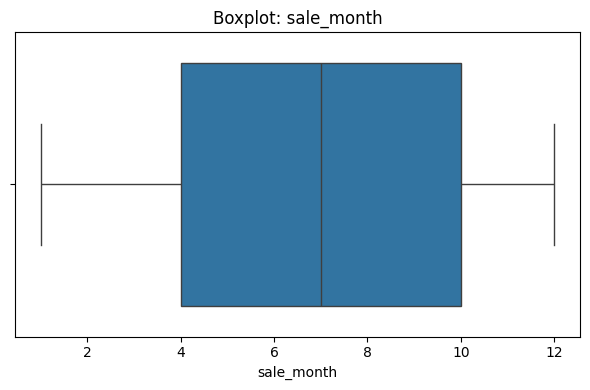

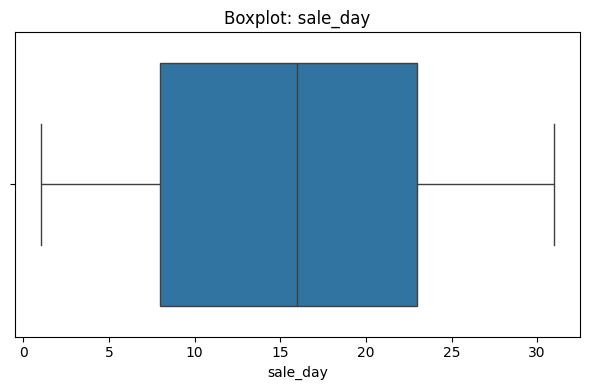

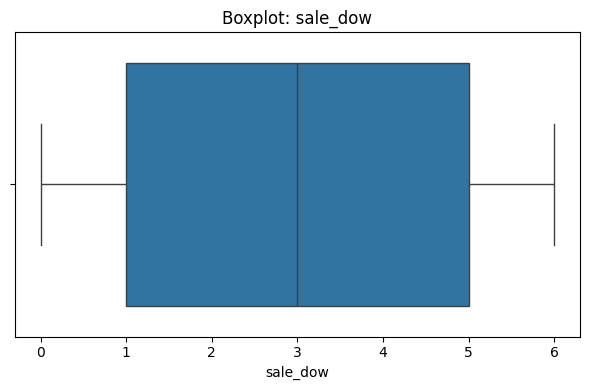

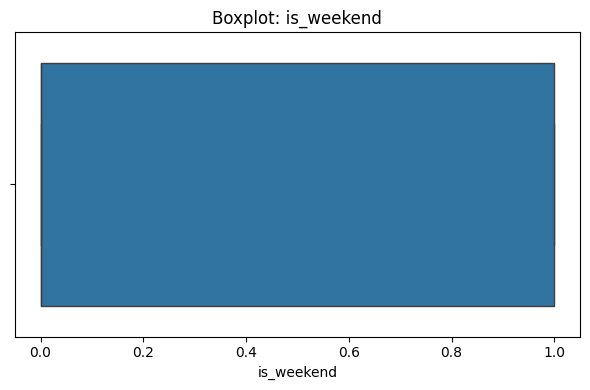

In [70]:
if num_cols:
    for col in num_cols:
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=df, x=col, orient="h")
        plt.title(f"Boxplot: {col}")
        plt.tight_layout()
        plt.show()

In [71]:

df.head()

,sale_id,customer_id,product_id,product_name,category,price,quantity,sale_date,age,gender,...,last_purchase_date,feedback_text,sentiment,total_value,total_value_log,sale_year,sale_month,sale_day,sale_dow,is_weekend
0,S000001,CUST01553,P004,Desk,Furniture,12000,2,2020-01-07,40,Female,...,2023-04-04,"Terrible experience, will not buy again.",Negative,24000,10.085851,2020,1,7,1,0
1,S000002,CUST00161,P010,Projector,Electronics,45000,2,2023-11-10,50,Female,...,2023-03-02,Excellent customer service.,Positive,90000,11.407576,2023,11,10,4,0
2,S000003,CUST00627,P010,Projector,Electronics,45000,4,2022-07-04,33,Male,...,2023-11-04,Product quality could be better.,Neutral,180000,12.100718,2022,7,4,0,0
3,S000004,CUST01291,P009,Monitor,Electronics,12000,1,2023-10-18,41,Male,...,2023-08-18,"Delivery was late, not happy.",Positive,12000,9.392745,2023,10,18,2,0
4,S000005,CUST01456,P004,Desk,Furniture,12000,4,2023-09-13,60,Female,...,2023-05-14,"Delivery was late, not happy.",Positive,48000,10.778977,2023,9,13,2,0


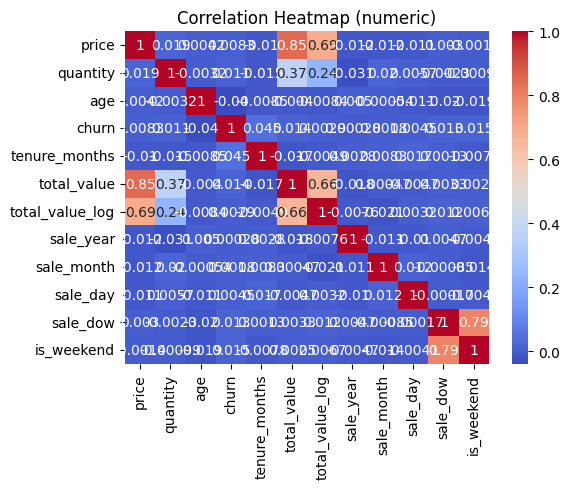

In [72]:
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap (numeric)")
    plt.tight_layout()
    plt.show()

In [73]:
df.head(10)

,sale_id,customer_id,product_id,product_name,category,price,quantity,sale_date,age,gender,...,last_purchase_date,feedback_text,sentiment,total_value,total_value_log,sale_year,sale_month,sale_day,sale_dow,is_weekend
0,S000001,CUST01553,P004,Desk,Furniture,12000,2,2020-01-07,40,Female,...,2023-04-04,"Terrible experience, will not buy again.",Negative,24000,10.085851,2020,1,7,1,0
1,S000002,CUST00161,P010,Projector,Electronics,45000,2,2023-11-10,50,Female,...,2023-03-02,Excellent customer service.,Positive,90000,11.407576,2023,11,10,4,0
2,S000003,CUST00627,P010,Projector,Electronics,45000,4,2022-07-04,33,Male,...,2023-11-04,Product quality could be better.,Neutral,180000,12.100718,2022,7,4,0,0
3,S000004,CUST01291,P009,Monitor,Electronics,12000,1,2023-10-18,41,Male,...,2023-08-18,"Delivery was late, not happy.",Positive,12000,9.392745,2023,10,18,2,0
4,S000005,CUST01456,P004,Desk,Furniture,12000,4,2023-09-13,60,Female,...,2023-05-14,"Delivery was late, not happy.",Positive,48000,10.778977,2023,9,13,2,0
5,S000006,CUST00634,P007,Pen Pack,Office Supplies,50,5,2022-10-22,51,Female,...,2023-11-14,Product quality could be better.,Neutral,250,5.525453,2022,10,22,5,1
6,S000007,CUST01463,P005,Printer,Electronics,15000,1,2022-05-07,57,Male,...,2023-01-18,Excellent customer service.,Positive,15000,9.615872,2022,5,7,5,1
7,S000008,CUST00235,P010,Projector,Electronics,45000,3,2020-04-19,35,Male,...,2023-06-28,"Terrible experience, will not buy again.",Negative,135000,11.813037,2020,4,19,6,1
8,S000009,CUST01822,P010,Projector,Electronics,45000,5,2023-01-14,24,Female,...,2023-05-26,Excellent customer service.,Positive,225000,12.323860,2023,1,14,5,1
9,S000010,CUST01772,P002,Smartphone,Electronics,25000,2,2022-05-16,53,Male,...,2023-03-05,"Delivery was late, not happy.",Positive,50000,10.819798,2022,5,16,0,0


In [74]:
import pandas as pd
import numpy as np
import nltk

df_fe = df.copy()

assert pd.api.types.is_datetime64_any_dtype(df_fe["sale_date"]), "sale_date must be datetime"
assert "total_value" in df_fe.columns, "total_value missing"
assert "total_value_log" in df_fe.columns, "total_value_log missing"
assert "is_weekend" in df_fe.columns and "sale_dow" in df_fe.columns, "derive date features first"

AS_OF_DATE = df_fe["sale_date"].max()
HIGH_TICKET_THR = df_fe["total_value"].quantile(0.90)

df_fe["feedback_text"] = df_fe.get("feedback_text", "").fillna("").astype(str).str.strip()
df_fe["has_feedback"] = (df_fe["feedback_text"].str.len() > 0).astype("uint8")

try:
    from nltk.sentiment import SentimentIntensityAnalyzer
except LookupError:
    nltk.download("vader_lexicon")
    from nltk.sentiment import SentimentIntensityAnalyzer
try:
    _ = nltk.data.find("sentiment/vader_lexicon.zip")
except LookupError:
    nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

def _score_text(t: str) -> float:
    return float(sia.polarity_scores(t)["compound"]) if t else 0.0

df_fe["sentiment_score"] = df_fe["feedback_text"].map(_score_text)

def _label_from_score(s: float) -> str:
    if s >= 0.30:   return "Positive"
    if s <= -0.30:  return "Negative"
    return "Neutral"

df_fe["sentiment_pred"] = df_fe["sentiment_score"].map(_label_from_score).astype("category")

sent_map = {"positive":"Positive", "negative":"Negative", "neutral":"Neutral"}
df_fe["sentiment_norm"] = np.where(
    df_fe["has_feedback"].eq(1),
    df_fe["sentiment_pred"].astype(str),
    np.nan,
)
if "sentiment" in df_fe.columns:
    df_fe.loc[df_fe["sentiment_norm"].isna(), "sentiment_norm"] = (
        df_fe["sentiment"].astype(str).str.lower().map(sent_map)
    )
df_fe["sentiment_norm"] = df_fe["sentiment_norm"].fillna("NoFeedback").astype("category")

df_fe["is_high_ticket"] = (df_fe["total_value"] > HIGH_TICKET_THR).astype("uint8")

def build_customer_features(g: pd.DataFrame) -> pd.Series:
    first_sale = g["sale_date"].min()
    last_sale  = g["sale_date"].max()
    orders     = int(len(g))

    m_sum   = float(g["total_value"].sum())
    m_med   = float(g["total_value"].median())
    m_max   = float(g["total_value"].max())
    q_mean  = float(g["quantity"].mean())
    q_max   = float(g["quantity"].max())
    p_mean  = float(g["price"].mean())

    dow_dist = g["sale_dow"].value_counts(normalize=True).reindex(range(7), fill_value=0.0)

    uniq_cat = int(g["category"].nunique())
    uniq_prod = int(g["product_id"].nunique())
    vc_cat = g["category"].value_counts(normalize=True)
    top_cat = vc_cat.index[0] if len(vc_cat) else np.nan
    top_cat_share = float(vc_cat.iloc[0]) if len(vc_cat) else 0.0

    with_fb = g[g["has_feedback"] == 1]
    pos = int((with_fb["sentiment_norm"] == "Positive").sum())
    neg = int((with_fb["sentiment_norm"] == "Negative").sum())
    neu = int((with_fb["sentiment_norm"] == "Neutral").sum())
    den = max(1, pos + neg + neu)
    neg_rate = float(neg / den)

    last_sent = g.sort_values("sale_date")["sentiment_norm"].iloc[-1] if len(g) else "NoFeedback"

    recent_mask = g["sale_date"] >= (AS_OF_DATE - pd.Timedelta(days=90))
    recent_neg_flag = int(((g.loc[recent_mask & (g["has_feedback"] == 1), "sentiment_norm"] == "Negative").sum()) > 0)

    feedback_count = int((g["has_feedback"] == 1).sum())
    feedback_rate = float(feedback_count / max(1, len(g)))

    g_sorted = g.sort_values("sale_date")
    age_latest = int(g_sorted["age"].iloc[-1])
    gender_mode = g["gender"].mode(dropna=False)
    gender_final = gender_mode.iloc[0] if not gender_mode.empty else np.nan
    region_mode = g["region"].mode(dropna=False)
    region_final = region_mode.iloc[0] if not region_mode.empty else np.nan

    tenure_days = int((last_sale - first_sale).days)
    recency_days = int((AS_OF_DATE - last_sale).days)

    high_ticket_rate = float(g["is_high_ticket"].mean())

    return pd.Series({
        "orders": orders,
        "first_sale": first_sale,
        "last_sale": last_sale,
        "tenure_days": tenure_days,
        "recency_days": recency_days,

        "monetary_sum": m_sum,
        "monetary_median": m_med,
        "monetary_max": m_max,

        "avg_quantity": q_mean,
        "max_quantity": q_max,
        "avg_price": p_mean,

        "dow_0_rate": float(dow_dist.loc[0]),
        "dow_1_rate": float(dow_dist.loc[1]),
        "dow_2_rate": float(dow_dist.loc[2]),
        "dow_3_rate": float(dow_dist.loc[3]),
        "dow_4_rate": float(dow_dist.loc[4]),
        "dow_5_rate": float(dow_dist.loc[5]),
        "dow_6_rate": float(dow_dist.loc[6]),

        "unique_categories": uniq_cat,
        "unique_products": uniq_prod,
        "top_category": top_cat,
        "top_category_share": top_cat_share,

        "sent_pos": pos,
        "sent_neg": neg,
        "sent_neu": neu,
        "neg_rate": neg_rate,
        "last_sentiment": last_sent,
        "recent_neg_flag": recent_neg_flag,
        "feedback_count": feedback_count,
        "feedback_rate": feedback_rate,

        "age_latest": age_latest,
        "gender": gender_final,
        "region": region_final,

        "high_ticket_rate": high_ticket_rate,
    })

gb = df_fe.groupby("customer_id", group_keys=False)
try:
    cust = gb.apply(build_customer_features, include_groups=False).reset_index()
except TypeError:
    cust = gb.apply(build_customer_features).reset_index()

y_cust = df_fe.groupby("customer_id")["churn"].max().rename("churn")
cust = cust.merge(y_cust, on="customer_id", how="left")

days = cust["tenure_days"].clip(lower=1)
cust["aov"] = cust["monetary_sum"] / cust["orders"].clip(lower=1)
cust["orders_per_30d"]   = cust["orders"] / (days / 30.0)
cust["monetary_per_30d"] = cust["monetary_sum"] / (days / 30.0)

cust.replace([np.inf, -np.inf], np.nan, inplace=True)
cust[["orders_per_30d","monetary_per_30d"]] = cust[["orders_per_30d","monetary_per_30d"]].fillna(0)

for c in ["gender", "region", "top_category", "last_sentiment"]:
    cust[c] = cust[c].astype("category")

cust_ml = pd.get_dummies(
    cust,
    columns=["gender", "region", "top_category", "last_sentiment"],
    drop_first=True,
    dtype=np.uint8
    )

drop_cols = [
    "first_sale", "last_sale",
    "dow_0_rate",
    "monetary_mean"
    ]
cust_ml.drop(columns=[c for c in drop_cols if c in cust_ml.columns], inplace=True, errors="ignore")

print(cust_ml.head(10))
print(f"Null vals: {cust_ml.isnull().sum()}")
print(f"Duplicate vals: {cust_ml.duplicated().sum()}")

X = cust_ml.drop(columns=["churn"], errors="ignore")
y = cust_ml["churn"].astype("uint8")
print("Churn Rate: ", y.mean())

print("Customers:", cust_ml.shape[0], "| Features:", X.shape[1])
print("Sample columns:", list(X.columns)[:20], "...")
X.corr(numeric_only=True).abs().unstack().sort_values(ascending=False).drop_duplicates().head(15)

  customer_id  orders  tenure_days  recency_days  monetary_sum  \
0   CUST00001       2           41           185      249000.0   
1   CUST00002       4          439           272       84300.0   
2   CUST00003       4         1019           242      130150.0   
3   CUST00004       5          920           455      349000.0   
4   CUST00005       1            0           811        8000.0   
5   CUST00006       5         1071           216      176500.0   
6   CUST00007       3         1286           164         450.0   
7   CUST00008       4          893           320      410200.0   
8   CUST00009       4          503           163      234000.0   
9   CUST00010       4          518           901      205500.0   

   monetary_median  monetary_max  avg_quantity  max_quantity     avg_price  \
0         124500.0      225000.0      3.500000           5.0  28500.000000   
1          24000.0       36000.0      2.750000           3.0   8025.000000   
2          42500.0       45000.0      3

orders             orders                1.000000
unique_products    feedback_count        0.891277
aov                monetary_median       0.868695
monetary_max       monetary_sum          0.868619
avg_price          aov                   0.850359
unique_categories  top_category_share    0.841629
high_ticket_rate   aov                   0.837728
aov                monetary_max          0.815383
avg_price          monetary_median       0.776021
sent_pos           orders                0.749319
sent_neg           neg_rate              0.732917
high_ticket_rate   monetary_max          0.725092
monetary_sum       aov                   0.708334
avg_quantity       max_quantity          0.702449
high_ticket_rate   monetary_median       0.686743
dtype: float64

In [75]:
linear_drop = [
    "aov", "monetary_median", "monetary_max", "avg_price",
    "unique_products", "max_quantity", "unique_categories"
 ]
X_linear = X.drop(columns=[c for c in linear_drop if c in X.columns])

# Outlier capping is commented out below
# for c in ["orders_per_30d", "monetary_per_30d"]:
#     p99 = X[c].quantile(0.99)
#     X[c] = X[c].clip(upper=p99)
#     if "X_linear" in globals() and c in X_linear.columns:
#         X_linear[c] = X_linear[c].clip(upper=p99)


In [76]:
# === Save engineered dataframes for modeling ===
cust_ml.to_csv("../data/customer_snapshot_ml.csv", index=False)
X_linear.to_csv("../data/customer_snapshot_Xlinear.csv", index=False)
print("Saved: customer_snapshot_ml.csv and customer_snapshot_Xlinear.csv")

Saved: customer_snapshot_ml.csv and customer_snapshot_Xlinear.csv
